In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_928_validation_set_label.png
/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_98_validation_set_label.png
/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_107_validation_set_label.png
/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_623_validation_set_label.png
/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_94_validation_set_label.png
/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_948_validation_set_label.png
/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_631_validation_set_label.png
/kaggle/input/lane-det

In [3]:
!pip install fastseg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.0 MB/s eta 0:00:00


In [4]:
!pip install fastai --upgrade


In [5]:
import albumentations  as albu
albu.__version__

'1.3.1'

In [6]:
from fastai.vision.all import *


In [7]:
import os
import matplotlib.pyplot as plt
import cv2
def get_image_array_from_fn(fn):
    image = cv2.imread(fn)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [8]:
DATA_DIR = "../input/lane-detection-for-carla-driving-simulator"

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_label')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_label')

In [9]:
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [10]:
def label_func(fn): 
    return str(fn).replace(".png", "_label.png").replace("train", "train_label").replace("val/", "val_label/")

../input/lane-detection-for-carla-driving-simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2267.png


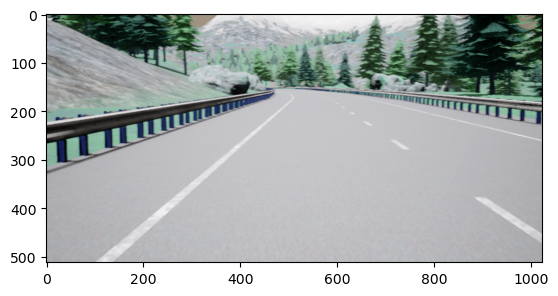

In [11]:
sample_fn = x_train_dir + "/" + os.listdir(x_train_dir)[0]
print(sample_fn)
plt.imshow(get_image_array_from_fn(sample_fn));

../input/lane-detection-for-carla-driving-simulator/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2267_label.png


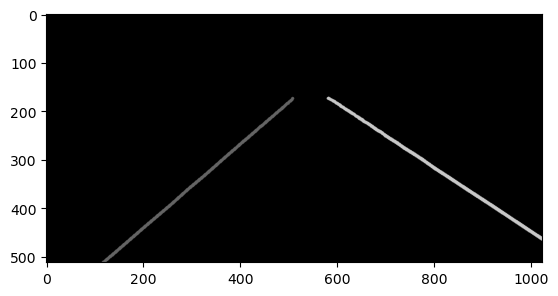

In [12]:
label_fn = label_func(sample_fn)
print(label_fn)
# we multiply the image intensity by 100 to make lane lines visible for the human eye:
plt.imshow(100*get_image_array_from_fn(label_fn)); 

In [13]:
my_get_image_files = partial(get_image_files, folders=["train", "val"])


In [14]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    

albu_transform_list = [
    albu.IAAAdditiveGaussianNoise(p=0.2),
    albu.OneOf(
        [
            albu.CLAHE(p=1),
            albu.RandomBrightness(p=1),
            albu.RandomGamma(p=1),
        ],
        p=0.6,
    ),
    albu.OneOf(
        [
            albu.IAASharpen(p=1),
            albu.Blur(blur_limit=3, p=1),
            albu.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.6,
    ),
    albu.OneOf(
        [
            albu.RandomContrast(p=1),
            albu.HueSaturationValue(p=1),
        ],
        p=0.6,
    ),
]
albu_transform = albu.Compose(albu_transform_list)

/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [15]:
codes = np.array(['back', 'left','right'],dtype=str)


In [16]:
carla = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = my_get_image_files,
                   get_y = label_func,
                   splitter = FuncSplitter(lambda x: str(x).find('validation_set')!=-1),
                   item_tfms=[SegmentationAlbumentationsTransform(albu_transform)])

In [17]:
dls = carla.dataloaders(Path(DATA_DIR), path=Path("."), bs=2)


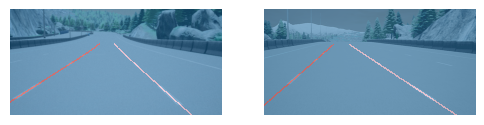

In [18]:
dls.show_batch(max_n=6)

In [19]:
from fastseg import MobileV3Small

model = MobileV3Small(num_classes=3, use_aspp=True, num_filters=8)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_small_100-37f49e2b.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_small_100-37f49e2b.pth


In [20]:
learn = Learner(dls, model, metrics=[DiceMulti()])

In [21]:
learn.fine_tune(5)


epoch,train_loss,valid_loss,dice_multi,time
0,0.012869,0.011914,0.883501,04:59


epoch,train_loss,valid_loss,dice_multi,time
0,0.009483,0.009579,0.896721,04:30
1,0.009397,0.009314,0.902897,03:57
2,0.008116,0.007265,0.930521,03:57
3,0.007091,0.006390,0.939572,03:57
4,0.006723,0.005986,0.944537,03:56


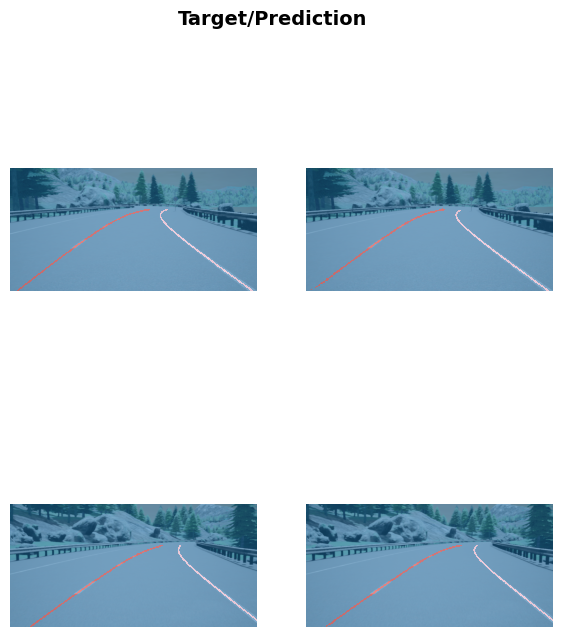

In [22]:
learn.show_results(max_n=6, figsize=(7,8))


In [23]:
torch.save(learn.model, './fastai_model.pth')


In [33]:
import cv2
img = cv2.imread(r'/kaggle/input/test111/test.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

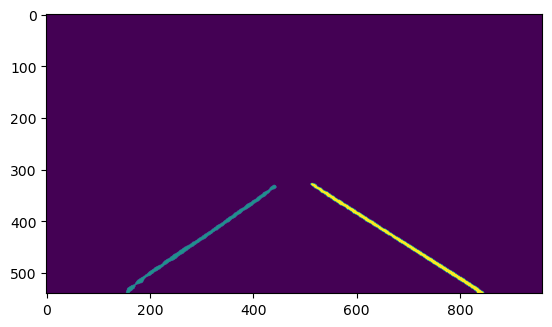

In [34]:
plt.imshow(np.array(learn.predict(img)[0]))


In [35]:
def get_pred_for_mobilenet(model, img_array):
    with torch.no_grad():
        image_tensor = img_array.transpose(2,0,1).astype('float32')/255
        x_tensor = torch.from_numpy(image_tensor).to("cuda").unsqueeze(0)
        model_output = F.softmax( model.forward(x_tensor), dim=1 ).cpu().numpy()
    return model_output

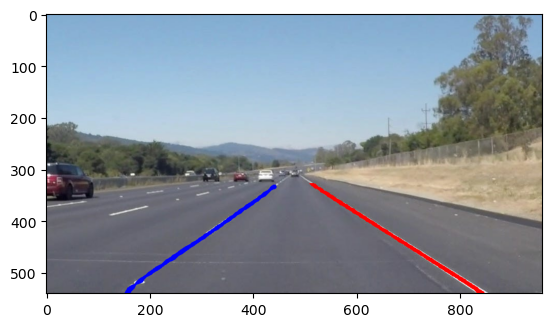

In [36]:
import copy
back, left, right = get_pred_for_mobilenet(learn.model,img)[0]
def ld_detection_overlay(image, left_mask, right_mask):
    res = copy.copy(image)
    res[left_mask > 0.3, :] = [0,0,255]
    res[right_mask > 0.3, :] = [255,0,0]
    return res
plt.imshow(ld_detection_overlay(img, left, right))